<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [1]:
# Import libraries.
import json
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis.gensim
import re
import squarify
import spacy

from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline

C:\Users\Me\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\Users\Me\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
# Load data.
df = pd.read_json('./data/review_sample.json', lines=True)

In [3]:
# Preview data.
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [4]:
# Check data dimensions.
df.shape

(10000, 9)

In [5]:
# Display range and distribution of star ratings.
df['stars'].value_counts()

5    4462
4    2185
1    1496
3    1098
2     759
Name: stars, dtype: int64

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [6]:
def tokenize(doc):
    """
    Accepts one document at a time; returns a list of tokens.
    """
    lemmas = []
    
    doc = nlp(doc)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) \
        and ((token.pos_!= 'PRON') and token.like_num == False):
            lemmas.append(token.lemma_)
    
    return lemmas

In [7]:
def clean(column):
    """
    Removes dollar signs and reduces any excess whitespace to a single
    space per instance.
    """
    column = column.copy()
    
    # Remove dollar signs.
    column = column.str.replace('$', '')
    
    # Reduce any excess whitespace to a single space per instance.
    column = column.str.replace(r'\s+', ' ')
    
    return column

In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
# Preprocess and clean text.
df['text'] = clean(df['text'])

In [10]:
# Generate tokens from text.
tokens = df['text'].apply(tokenize)

In [11]:
# Preview tokens.
tokens[0]

['beware',
 'fake',
 'fake',
 'fake',
 'small',
 'business',
 'Los',
 'Alamitos',
 'receive',
 'look',
 'like',
 'legitimate',
 'bill',
 'account',
 'number',
 'call',
 'phone',
 'number',
 'list',
 'wait',
 'time',
 'hold',
 'say',
 'minute',
 'leave',
 'message',
 'live',
 'person',
 'phone',
 'matter',
 'number',
 'select',
 'leave',
 'firm',
 'message',
 'contact',
 'BBB',
 'attorney',
 'company',
 'try',
 'scam',
 'business',
 'illegal']

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

### Create a vector representation of the reviews

In [12]:
# Instantiate vectorizer object.
tfidf = TfidfVectorizer(min_df=0.01, 
                        max_df=0.98,
                        ngram_range=(1,2))

# Create a vocabulary and get word counts per document.
dtm = tfidf.fit_transform(tokens.astype(str))

# Get feature names to use as dataframe column headers.
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# Preview feature matrix.
dtm.head()

,30,able,absolutely,accommodate,actually,add,affordable,afternoon,ago,agree,...,wrap,write,wrong,year,year ago,yelp,yes,young,yum,yummy
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.095275,0.0,0.0,0.0,0.146312,0.0,0.0
3,0.0,0.0,0.0,0.0,0.254845,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [13]:
# Instantiate nearest neighbors model.
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

# Fit on TF-IDF Vectors
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### Write a fake review and query for the 10 most similiar reviews

Print the text of the reviews. Do you notice any patterns?

In [14]:
# Create a fake negative review.
bad_review = ('Boy, the food at this place is really terrible, and '
              'such small portions.')

In [15]:
# Vectorize fake review.
bad_vec = tfidf.transform([bad_review])

In [16]:
# Find 10 most similar reviews.
bad_distances, bad_indices = nn.kneighbors(bad_vec.todense(), 10)

In [17]:
# Print star ratings and abbreviated text of similar reviews.
df.iloc[bad_indices[0]][['stars', 'text']]

,stars,text
2627,1,"Terrible terrible terrible went to get a ""hot ..."
2135,1,Terrible airline. They have nothing to offer a...
3230,1,This place just sucks. Food was terrible. Serv...
5298,1,Terrible.. absolutely terrible. Dr. Hinds is e...
7006,1,Yuk! Terrible pizza! I think I got food poison...
5366,1,Don't shop here. The owner John Menard is PURE...
4673,2,Terrible terrible terrible. After they lost my...
6204,5,旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。 質問にも丁寧に...
6311,5,天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用...
1104,1,Fries were burnt to shit. Jalapeños were so bu...


In [18]:
# Print full text of similar reviews.
for text in df.iloc[bad_indices[0]]['text']:
    print(f'{text}\n')

Terrible terrible terrible went to get a "hot and ready pizza and box" which is supposed to be ready between the hours of 4 and 8 p.m. at 7:24 p.m. here it is 8 p.m. and I still have not received my order which I was told would be ready in 12 to 15 minutes this place is terrible terrible terrible and I will no longer be spending my money at this particular little Little Caesars if any Little Caesars Domino's here I come

Terrible airline. They have nothing to offer accept a ride. Why is it that airlines have terrible business models? Virgin America is my favorite. We need more Airlines like them.

This place just sucks. Food was terrible. Service was even worse some how. Just skip it all together.

Terrible.. absolutely terrible. Dr. Hinds is especially rude, very difficult to get anyone to return a phone call, just overall terrible patient care.

Yuk! Terrible pizza! I think I got food poisoning!! Yuk! Yuk! Yuk! Yuk! Yuk! Yuk! Yik! Still Yuk!!!!!@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Yikes yu

#### Observations

Unsurprisingly, our model does not handle non-English reviews well. With that exception noted, however, it otherwise does seem to do well at identifying clearly negative reviews.

On the other hand, the model does not seem to reliably pick up on the type of business being reviewed - we have an airline, a couple of medical providers, a hardware store, and several restaurant reviews all lumped together here.

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a pipeline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

### Create a Pipeline

Create a pipeline object with a sklearn CountVectorizer or TfidfVectorizer and any sklearn classifier. Use that pipeline to estimate a model to predict stars. Use the pipeline to predict a star rating for your fake review from Part 2.

In [19]:
# Create pipeline components.
vectorizer = TfidfVectorizer()
classifier = KNeighborsClassifier()

In [20]:
# Define the pipeline.
pipe = Pipeline([('vect', vectorizer), 
                 ('clf', classifier)])

In [21]:
# Fit pipeline to data.
pipe.fit(tokens.astype(str), df['stars'])

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,


In [22]:
# Use the pipeline to predict a star rating for a fake review.
pipe.predict([bad_review])

array([1], dtype=int64)

As expected, the pipeline predicts the lowest possible rating for this clearly negative review.

### Tune the Pipeline

Tune the entire pipeline with a GridSearch.

In [23]:
# Define parameter space for exploration.
parameters = {
    'vect__max_df': (0.95, 0.98),
    'vect__min_df': (0.02, 0.05),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__n_neighbors': (5, 10),
    'clf__weights':('uniform', 'distance')
}

In [24]:
# Search parameter space for best model.
grid_search = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(tokens.astype(str), df['stars'])

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [25]:
# Get accuracy of best model.
grid_search.best_score_

0.4784

In [26]:
# Compare to baseline accuracy.
accuracy_score([5]*len(df['stars']), df['stars'])

0.4462

That's pretty terrible! How wrong _are_ our mis-classified star ratings, though?

In [27]:
# Re-search grid, but penalize degree of error.
grid_search_mae = GridSearchCV(pipe, 
                               parameters, 
                               scoring='neg_mean_absolute_error', 
                               cv=3, 
                               n_jobs=-1, 
                               verbose=1)
grid_search_mae.fit(tokens.astype(str), df['stars'])

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [28]:
# Get MAE of best model.
abs(grid_search_mae.best_score_)

0.979

So on average, we're off by about one star. Not great, but not _terrible_ terrible either.

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate an LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

### Create generator

In [29]:
def doc_stream(filename):
    with open(filename) as f:
        for line in f:
            text = ' '.join(json.loads(line.strip())['text'].split())
            text = text.replace('$', '')
            tokens = tokenize(str(text))
            yield tokens

In [30]:
streaming_data = doc_stream('./data/review_sample.json')

### Estimate an LDA topic model of the review text

In [31]:
# Create dictionary.
id2word = corpora.Dictionary(doc_stream('./data/review_sample.json'))

In [32]:
# Check size of dictionary.
len(id2word.keys())

27573

In [33]:
# Remove extreme values from dataset. The "no above"
# here seems really low, but we have a lot of potential 
# stopwords turning up in our dictionary.
id2word.filter_extremes(no_below=5, no_above=0.05)

In [34]:
# Check size of filtered dictionary.
len(id2word.keys())

6183

In [35]:
# A bag of words(bow) representation of our corpus.
corpus = [id2word.doc2bow(review) for review in tokens]

In [36]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=0,
                   iterations=5,
                   workers=4,
                   num_topics = 6 # You can change this parameter
                  )

In [37]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:10]) for t in words]

In [38]:
# List most common words for each topic.
for id, t in enumerate(topics):
    print(f'Topic {id+1}: {t}')
    print("\n")

Topic 1: pizza store sandwich stay line old month owner car meat


Topic 2: burger seat roll coffee cut store car perfect pizza stay


Topic 3: store coffee car hotel free deal cream atmosphere busy soup


Topic 4: store meat line pizza coffee stay sandwich shop option car


Topic 5: car beer owner house spot pizza cook ice high option


Topic 6: pizza use family perfect store waitress sushi stay shop sandwich




### Create 1-2 visualizations of the results

You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 

In [39]:
pyLDAvis.enable_notebook()

In [40]:
# Plot 2-dimensional projection of topics.
pyLDAvis.gensim.prepare(lda, corpus, id2word)

C:\Users\Me\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.000836  0.006377       1        1  16.918194
3     -0.004867  0.001271       2        1  16.727600
4      0.006892 -0.001014       3        1  16.660599
0     -0.002937 -0.002389       4        1  16.635979
1      0.000195  0.001031       5        1  16.554945
2     -0.000119 -0.005277       6        1  16.502676, topic_info=     Category        Freq        Term       Total  loglift  logprob
608   Default  645.000000      burger  645.000000  30.0000  30.0000
812   Default  619.000000      coffee  619.000000  29.0000  29.0000
524   Default  812.000000       store  812.000000  28.0000  28.0000
414   Default  548.000000     perfect  548.000000  27.0000  27.0000
219   Default  436.000000         cut  436.000000  26.0000  26.0000
644   Default  565.000000    sandwich  565.000000  25.0000  25.0000
328   Default  539.000000        roll  539.000000  24.0000  24.0000
89    Default  293.000000      noodle  293.000000  23.0000  23.0000
719   Default  509.000000         use  509.000000  22.0000  22.0000
370   Default  527.000000      family  527.000000  21.0000  21.0000
206   Default  467.000000    waitress  467.000000  20.0000  20.0000
504   Default  481.000000       sushi  481.000000  19.0000  19.0000
799   Default  378.000000         dog  378.000000  18.0000  18.0000
514   Default  488.000000        deal  488.000000  17.0000  17.0000
727   Default  271.000000        pool  271.000000  16.0000  16.0000
246   Default  765.000000       pizza  765.000000  15.0000  15.0000
532   Default  686.000000         car  686.000000  14.0000  14.0000
1648  Default  434.000000       house  434.000000  13.0000  13.0000
7     Default  373.000000     company  373.000000  12.0000  12.0000
53    Default  605.000000        line  605.000000  11.0000  11.0000
1138  Default  260.000000    remember  260.000000  10.0000  10.0000
1299  Default  486.000000       hotel  486.000000   9.0000   9.0000
182   Default  360.000000        nail  360.000000   8.0000   8.0000
1811  Default  307.000000      office  307.000000   7.0000   7.0000
298   Default  246.000000    horrible  246.000000   6.0000   6.0000
51    Default  465.000000         kid  465.000000   5.0000   5.0000
789   Default   85.000000      polish   85.000000   4.0000   4.0000
495   Default  464.000000         ice  464.000000   3.0000   3.0000
464   Default  601.000000        beer  601.000000   2.0000   2.0000
407   Default  317.000000        girl  317.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
2299   Topic6   36.430019      honest  153.944824   0.3604  -7.1364
136    Topic6   26.783480  perfection  109.895332   0.3899  -7.4440
401    Topic6   92.665062      couple  438.611542   0.2470  -6.2028
1552   Topic6   71.734833      finish  331.204590   0.2719  -6.4588
324    Topic6   59.841953    question  270.220032   0.2941  -6.6401
45     Topic6   95.625717        fast  460.585693   0.2296  -6.1713
93     Topic6  102.153053        soup  499.069489   0.2154  -6.1053
516    Topic6  115.613983        free  579.823608   0.1892  -5.9815
170    Topic6   93.135429         far  454.486389   0.2165  -6.1977
492    Topic6  109.122978       cream  546.950684   0.1898  -6.0393
524    Topic6  150.632660       store  812.478394   0.1164  -5.7169
152    Topic6  103.760948        busy  521.653564   0.1867  -6.0897
373    Topic6   99.013992         job  497.196045   0.1879  -6.1365
532    Topic6  128.042435         car  686.201111   0.1228  -5.8794
1243   Topic6   85.330612        half  420.816589   0.2060  -6.2852
174    Topic6   95.271828        high  489.183838   0.1656  -6.1750
815    Topic6   79.789543         egg  385.630646   0.2262  -6.3524
587    Topic6  102.132439        item  555.753967   0.1076  -6.1055
456    Topic6   83.731255         run  417.265015   0.1955  -6.3042
864    Topic6   85.427849        taco  443.946655   0.153

In [41]:
# Define weightings for top ten words in each topic.
weights = [[float(f) for f in re.findall(r'([\d.]{5})', topic[1])] \
           for topic in lda.print_topics()]

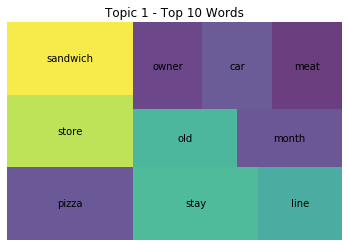

In [42]:
# Plot top 10 words for topic 1.
squarify.plot(sizes=weights[0], label=words[0], alpha=0.8)
plt.axis('off')
plt.title('Topic 1 - Top 10 Words')
plt.show()

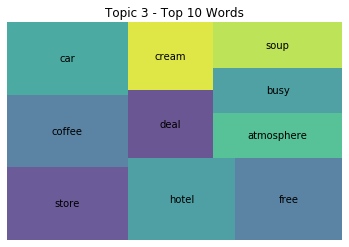

In [43]:
#Plot top 10 words for topic 3.
squarify.plot(sizes=weights[2], label=words[2], alpha=0.8)
plt.axis('off')
plt.title('Topic 3 - Top 10 Words')
plt.show()

### Analysis of Topic Model

In markdown, write 1-2 paragraphs of analysis on the results of your topic model.

This topic model is pretty worthless, honestly. They look distinct on the 
intertopic distance visualization, but the top 10 word lists don't provide 
a clear differentiation between each.

It's not immediately clear which topics have more positive or negative 
reviews, and it looks like all of topics are being swamped by food and/or
restaurant reviews, which are in a sense "drowning out" the other reviews 
in the dataset.

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)